# 菜单 <a id="menu"></a>
[跳转至验证码下载](#main)

# 验证码基本操作

In [1]:
#http://www.7wenta.com/captcha?len=6&1498445214972
#获取验证码图片
#方式：get

#http://www.7wenta.com/captchaCheck.json?1498445767649
#检查验证码
#方式：post
#参数：word、fromSearch：false

import requests
from PIL import Image
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import random

def GetTimeString():
    return str(int(time.time()))+str(random.randint(0,9))+str(random.randint(0,9))+str(random.randint(0,9))

def LoadPic(address):
    img = Image.open(address)
    width,height = img.size
    img = img.convert('L')
    imgData = img.getdata()
    imgData = np.matrix(imgData,dtype='float')
    imgData = np.reshape(imgData,(height,width))
    imgData[imgData>180] = 255
    imgData[imgData<=180] = 0
    fig,ax = plt.subplots()
    plt.imshow(imgData,cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    print(height,width)
    return imgData,height,width

def ShowImg(img):
    fig,ax = plt.subplots()
    ax.imshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

# 字符分割

In [2]:
def SplitImg(img, letter=0, threshold=0):
    matrix = (255 - img) / 255.0
    sep = []
    sepPnt = [0]
    sepLen = []
    if threshold == 0:
        threshold = 0.05
        shadow = np.sum(matrix,0) / height
        while len(sepPnt)<2 * letter + 1:
            sep = []
            sepPnt = [0]
            sepLen = []
            for i in range(len(shadow.T.tolist())):
                if shadow[0,i] < threshold:
                    sep.append(0)
                else:
                    sep.append(1)
                if len(sep)>1 and sep[-1] != sep[-2]:
                    sepPnt.append(i)
                    sepLen.append(sepPnt[-1]-sepPnt[-2])
            sepLen.append(width - sepPnt[-1] + 1)
            threshold += 0.01
            
    elif letter == 0:
        shadow = np.sum(matrix,0) / height
        for i in range(len(shadow.T.tolist())):
            if shadow[0,i] < threshold:
                sep.append(0)
            else:
                sep.append(1)
            if len(sep)>1 and sep[-1] != sep[-2]:
                sepPnt.append(i)
                sepLen.append(sepPnt[-1]-sepPnt[-2])
        sepLen.append(width - sepPnt[-1] + 1)
    else:
        return
    print(len(sep))
    print(sepPnt)
    print(sepLen)
    for i in range(width):
        if sep[i] == 0:
            for j in range(height):
                img[j,i] = 200
    return img


# 删除水平线

In [3]:
def DeleteLine(img,length,thickness):
    matrix = (255 - img)/255.0
    for i in range(height):
        line = 0
        for j in range(width):
            if matrix[i,j] == 1:
                line += 1
            else:
                if line >= length:
                    for k in range(j-line,j):
                        up = 0
                        down = 0
                        for m in range(10):
                            if i-m>=0 and matrix[i-m,k] == 1:
                                down += 1
                            else:
                                break
                        for m in range(10):
                            if i+m<height and matrix[i+m,k] == 1:
                                up += 1
                            else:
                                break
                        if up+down<=thickness-1:
                            matrix[i-down:i+up,k] = 0
                line = 0
        if line>=length:
            for k in range(width-line,width):
                up = 0
                down = 0
                for m in range(10):
                    if i-m>=0 and matrix[i-m,k] == 1:
                        down += 1
                    else:
                        break
                for m in range(10):
                    if i+m<height and matrix[i+m,k] == 1:
                        up += 1
                    else:
                        break
                if up+down<=thickness-1:
                    matrix[i-down:i+up,k] = 0
            #matrix[i,width-line:width-1] = 0
    img = 255 - matrix * 255.0
    return img

# 删除孤立点

In [4]:
def DeletePoint(img):
    matrix = (255 - img)/255.0
    temp_matrix = matrix
    for i in range(height):
        for j in range(width):
            temp = 0
            num = 0
            if i>0:
                num+=1
                if temp_matrix[i-1,j] == 1:
                    temp+=1
            if i>0 and j>0:
                num+=1
                if temp_matrix[i-1,j-1] == 1:
                    temp+=1
            if j>0:
                num+=1
                if temp_matrix[i,j-1] == 1:
                    temp+=1
            if j>0 and i<height-1:
                num+=1
                if temp_matrix[i+1,j-1] == 1:
                    temp+=1
            if i<height-1:
                num+=1
                if temp_matrix[i+1,j] == 1:
                    temp+=1
            if i<height-1 and j<width-1:
                num+=1
                if temp_matrix[i+1,j+1] == 1:
                    temp+=1
            if j<width-1:
                num+=1
                if temp_matrix[i,j+1] == 1:
                    temp+=1
            if j<width-1 and i>0:
                num+=1
                if temp_matrix[i-1,j+1] == 1:
                    temp+=1
            if temp < num/2:
                matrix[i,j] = 0
            #else:
            #    matrix[i,j] = 1
    
    img = 255 - matrix * 255.0
    return img

# 删除小块

In [62]:
def DeleteChunk(img,area):
    matrix = (255 - img)/255.0
    
    newPt = set()
    oldPt = set()
    savePt = set()
    for i in range(height):
        for j in range(width):
            if matrix[i,j] == 1 and (i,j) not in oldPt:
                #print('find point (%d, %d)' % (i,j))
                newPt.add((i,j))
                savePt.add((i,j))
                S = 1
                while len(newPt) > 0:
                    pt = newPt.pop()
                    oldPt.add(pt)
                    if pt[0]+1<height and matrix[pt[0]+1,pt[1]] == 1 and (pt[0]+1,pt[1]) not in oldPt and (pt[0]+1,pt[1]) not in savePt:
                        newPt.add((pt[0]+1,pt[1]))
                        savePt.add((pt[0]+1,pt[1]))
                        S += 1
                    if pt[0]-1>=0 and matrix[pt[0]-1,pt[1]] == 1 and (pt[0]-1,pt[1]) not in oldPt and (pt[0]-1,pt[1]) not in savePt:
                        newPt.add((pt[0]-1,pt[1]))
                        savePt.add((pt[0]-1,pt[1]))
                        S += 1
                    if pt[1]+1<width and matrix[pt[0],pt[1]+1] == 1 and (pt[0],pt[1]+1) not in oldPt and (pt[0],pt[1]+1) not in savePt:
                        newPt.add((pt[0],pt[1]+1))
                        savePt.add((pt[0],pt[1]+1))
                        S += 1
                    if pt[1]-1>=0 and matrix[pt[0],pt[1]-1] == 1 and (pt[0],pt[1]-1) not in oldPt and (pt[0],pt[1]-1) not in savePt:
                        newPt.add((pt[0],pt[1]-1))
                        savePt.add((pt[0],pt[1]-1))
                        S += 1
                #print(S)
                if S <= area:
                    #print('Delete chunk!')
                    for point in savePt:
                        matrix[point[0],point[1]] = 0
                savePt.clear()
        
    img = 255 - matrix * 255.0
    return img

# 验证码下载 <a id="main"></a> [返回](#menu)

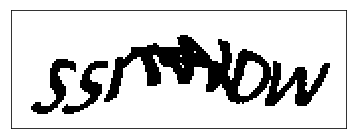

60 170


In [67]:
session = requests.session()
response = session.get('http://www.7wenta.com/captcha?len=6&%s'%GetTimeString())
with open('验证码图片/test.jpg', 'wb') as wf:
    for chunk in response.iter_content(128):
        wf.write(chunk)
imgData,height,width = LoadPic('验证码图片/test.jpg')

In [70]:
name = 'ssnwow'
data = {
    'word':name,
    'fromSearch':False
}
response = session.post('http://www.7wenta.com/captchaCheck.json?%s'%GetTimeString(),data=data)
js = json.loads(response.content.decode())
if js['resultCode']['code'] == 0:
    os.rename('验证码图片/test.jpg', '验证码图片/%s.jpg'%name)
    print('保存成功！')
    session.close
elif js['resultCode']['code'] == -5:
    print('验证码错误！')
else:
    print('异常返回！')

保存成功！


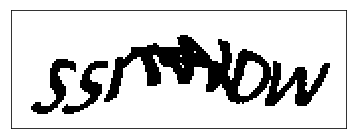

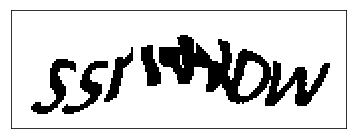

In [71]:
ShowImg(imgData)
img = imgData
img = DeleteLine(img,20,8)
#img = DeletePoint(img)
#img = DeleteChunk(img, 50)
#img = SplitImg(img, threshold=0.15)
ShowImg(img)

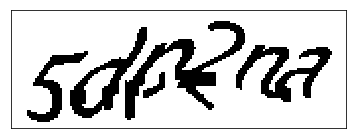

5c/F%’r47


In [61]:
import pytesseract
from PIL import Image
#print(pytesseract.image_to_string(Image.open('验证码图片/0.jpg')).replace(' ',''))
i = Image.fromarray(img.astype(np.uint8))
print(pytesseract.image_to_string(i).replace(' ',''))